In [1]:
# !pip install -q pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install warnings
# !pip install numpy
# !pip install scipy

In [13]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import cm

In [14]:
# Import the required MaxQuant output tables
df_pG=pd.read_csv("proteinGroups.txt",delimiter="\t")
df_pep=pd.read_csv("peptides.txt",delimiter="\t")
df_ev=pd.read_csv("evidence.txt",delimiter="\t")

In [15]:
# Filtering the MaxQuant output table for valid identifications and calculating these on protein group level
df_pG_filtered = df_pG[(df_pG["Only identified by site"]!="+") & (df_pG["Reverse"]!="+") & (df_pG["Potential contaminant"]!="+")]
num_protein_groups = len(df_pG_filtered['Protein IDs'].drop_duplicates())
print("Number of protein groups: ", num_protein_groups)

Number of protein groups:  2383


In [16]:
# Filtering the MaxQuant output table for valid identifications and calculating these on peptide level
df_pep_filtered = df_pep[(df_pep["Reverse"]!="+") & (df_pep["Potential contaminant"]!="+")]
num_peptides = len(df_pep_filtered['Sequence'].drop_duplicates())
print("Number of peptides: ", num_peptides)

Number of peptides:  14106


In [17]:
# Filtering the MaxQuant output table for valid identifications
df_ev_filtered = df_ev[(df_ev["Reverse"]!="+") & (df_ev["Potential contaminant"]!="+")]
df_ev_filtered[df_ev_filtered == 0] = np.nan

In [18]:
# Calculation of the absolute value for mass error and calculating the median of it
df_ev_filtered["Mass error [ppm] - absolute value"] = abs(df_ev_filtered["Mass error [ppm]"])
df_ev_filtered["Uncalibrated mass error [ppm] - absolute value"] = abs(df_ev_filtered["Uncalibrated mass error [ppm]"])

median_absolute_mass_error = df_ev_filtered["Mass error [ppm] - absolute value"].median()
median_absolute_uncalibrated_mass_error = df_ev_filtered["Uncalibrated mass error [ppm] - absolute value"].median()

print("Median absolute mass error: ", median_absolute_mass_error)
print("Median absolute uncalibrated mass error: ", median_absolute_uncalibrated_mass_error)

Median absolute mass error:  2.9756
Median absolute uncalibrated mass error:  2.7284


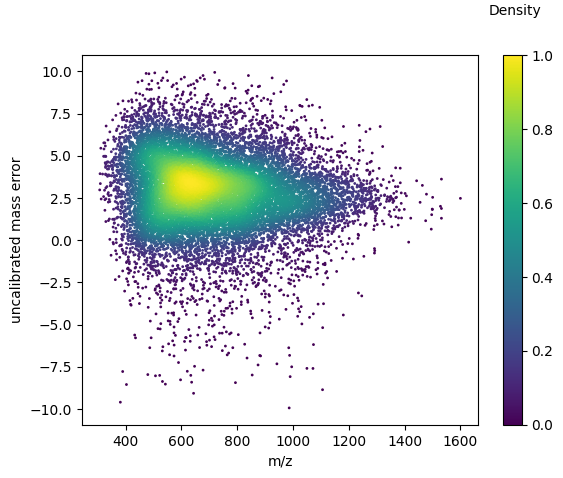

In [19]:
# density plot of the uncalibrated mass error

xx = df_ev_filtered["m/z"]
yy = df_ev_filtered["Mass error [ppm]"]
kde = stats.gaussian_kde([xx,yy])
zz = kde([xx,yy])
zz.min(),zz.max()
cc = cm.viridis((zz-zz.min())/(zz.max()-zz.min()))
cc.min(),cc.max()
a = plt.scatter(xx,yy,marker='o',facecolors=cc,s=1)
plt.xlabel("m/z")
plt.ylabel("uncalibrated mass error")
plt.colorbar().set_label('Density', labelpad=-28, y=1.14, rotation=0)
plt.savefig('mz_against_uncalibrated_mass_error.png', dpi=300)

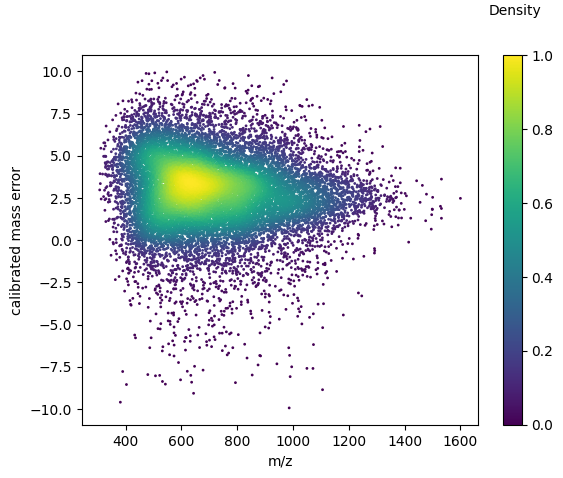

In [20]:
# density plot of the mass error

xx = df_ev_filtered["m/z"]
yy = df_ev_filtered["Mass error [ppm]"]
kde = stats.gaussian_kde([xx,yy])
zz = kde([xx,yy])
zz.min(),zz.max()
cc = cm.viridis((zz-zz.min())/(zz.max()-zz.min()))
cc.min(),cc.max()
a = plt.scatter(xx,yy,marker='o',facecolors=cc,s=1)
plt.xlabel("m/z")
plt.ylabel("calibrated mass error")
plt.colorbar().set_label('Density', labelpad=-28, y=1.14, rotation=0)
plt.savefig('mz against mass error.png', dpi=300)

In [21]:
# Converting retention time columns from min to sec
def calc_sec(sec):
    sec = sec * 60
    return sec

read_cols = ["Retention length", "Calibrated retention time", "Calibrated retention time start", "Calibrated retention time finish"]
write_cols = ["Retention length in s", "Calibrated retention time in s", "Calibrated retention time start in s", "Calibrated retention time finish in s"]

for i in range(len(read_cols)):
    df_ev_filtered[write_cols[i]] = df_ev_filtered[read_cols[i]].apply(lambda x: calc_sec(x))
    
# Calculation of the peak shape and peak width
df_ev_filtered["c.r.t.f.-c.r.t."] = df_ev_filtered["Calibrated retention time finish in s"] - df_ev_filtered["Calibrated retention time in s"]
df_ev_filtered["c.r.t.-c.r.t.s."] = df_ev_filtered["Calibrated retention time in s"] - df_ev_filtered["Calibrated retention time start in s"]
df_ev_filtered["peak tailing"] = df_ev_filtered["c.r.t.f.-c.r.t."] / df_ev_filtered["c.r.t.-c.r.t.s."]

peak_shape = np.median([ item for item in df_ev_filtered["peak tailing"] if item!= float('inf') and not np.isnan(item)])
peak_width = np.median([ item for item in df_ev_filtered["Retention length in s"] if item!= float('inf') and not np.isnan(item)])

print("Peak shape: ", peak_shape)
print("Peak width [s]: ", peak_width)

Peak shape:  1.3250000000000155
Peak width [s]:  7.980599999999999


In [22]:
# Saving all calculated values in a dataframe and csv file.
dict_DDA = dict()
dict_DDA["Number of protein groups"] = num_protein_groups
dict_DDA["Number of peptides"] = num_peptides
dict_DDA["Median absolute mass error"] = median_absolute_mass_error
dict_DDA["Median absolute uncalibrated mass error"] = median_absolute_uncalibrated_mass_error
dict_DDA["Peak shape"] = peak_shape
dict_DDA["Peak width [s]"] = peak_width

#Saving the dictonary as csv
pd.DataFrame({"column name": list(dict_DDA.keys()),
              "column value": list(dict_DDA.values())}).to_csv("DDA_calculation.csv", index=False)

dict_DDA

{'Number of protein groups': 2383,
 'Number of peptides': 14106,
 'Median absolute mass error': 2.9756,
 'Median absolute uncalibrated mass error': 2.7284,
 'Peak shape': 1.3250000000000155,
 'Peak width [s]': 7.980599999999999}